### Random Forests and Photo-zs

In this notebook, we use Random Forests to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). It accompanies Chapter 6 of the book (1 of 4).

Copyright: Viviana Acquaviva (2023); see also other data credits below.

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/). Additionally, we are very grateful to Jeff Newman for his expert advice.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [ ]:
import astropy

from astropy.io import fits

#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

#### Data import

We can read the data into a data frame using pandas:

In [ ]:
with fits.open('DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [ ]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

In [ ]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [ ]:
df.shape

(23822, 78)

We can select the columns we want, corresponding to the brightness of the galaxies in the six bands of interest.

In [ ]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

The target property is the redshift. For this catalog, spectroscopic (more precise) redshifts, to use as the ground truth, are available in the column "zhelio".

In [ ]:
target = df['zhelio']

In [ ]:
features.head(10)

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
5,23.552186,23.420734,23.010863,22.550723,22.277656,21.860866
6,23.983330,24.104438,23.461145,23.359428,22.929944,22.690175
7,24.665840,24.408938,23.544115,23.155140,22.706477,22.894691
8,23.518039,22.746858,21.571629,20.645176,20.428926,20.306110
9,22.755723,21.915841,21.393365,21.148952,21.052236,20.830114


In [ ]:
target.head(10)

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
5    0.909043
6    0.502974
7    0.649839
8    0.679440
9    0.074078
Name: zhelio, dtype: float32

### Ok, we are now ready to run our first Random Forest model!

To get an idea of what we are shooting for, we can look at a figure in the paper:

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15.

To be fair, we are working with DEEP2/3 data, so our range is slightly different.

In [ ]:
model = RandomForestRegressor()

In [ ]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We begin by establishing a benchmark (note: it takes a little time; ~35 secs on my machine).

In [ ]:
scores = cross_validate(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

{'fit_time': array([7.06981707, 7.0001359 , 6.97375894, 6.98413491, 6.99706221]),
 'score_time': array([0.105896  , 0.09559298, 0.09412813, 0.09610295, 0.09632277]),
 'test_score': array([0.30009794, 0.31114676, 0.31311615, 0.30385479, 0.31835601]),
 'train_score': array([0.87340818, 0.87872604, 0.87628967, 0.87617119, 0.87476926])}

As a reminder, the scores are the R2 score at this point.

In [ ]:
np.mean(scores['test_score'])

0.30931433249368495

In [ ]:
np.mean(scores['train_score'])

0.8758728672881155

Looks like we have a severe high variance issue! Let's also check the predictions and plot them against the true values.

In [ ]:
ypred = cross_val_predict(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 3)

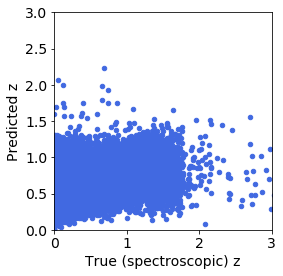

In [ ]:
plt.scatter(target,ypred, s = 20, c = 'royalblue')
plt.xlabel('True (spectroscopic) z', fontsize=14)
plt.ylabel('Predicted z',fontsize=14)
plt.axis('square')
plt.xlim(0,3)
plt.ylim(0,3)

### Question: Does it look like the one of the paper?

It's also interesting to look at the distribution of the predicted values, to see how they always tend to produce a narrower distribution. Why?

This is a characteristic of tree-based methods; examples with very low/high values of the target are "bunched up" with others that have higher/lower values, so the predictions tend to be over-estimated for low values of the target variables and under-estimated for high values. You can usually see this trend in scatter plots as well! 

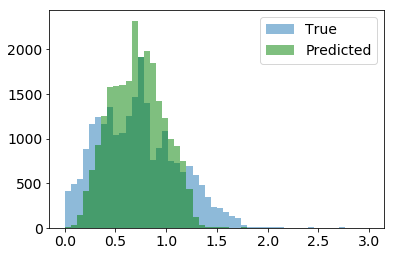

In [ ]:
plt.hist(target,bins=50,density=False,alpha=0.5, range = (0,3), label = 'True');
plt.hist(ypred,bins=50,density=False,alpha=0.5, range = (0,3), color = 'g', label = 'Predicted');
plt.legend(fontsize=14);

Ok, we are now ready to calculate the outlier fraction:

In [ ]:
len(np.where(np.abs(target-ypred)>0.15*(1+target))[0])/len(target)

0.2577449416505751

And NMAD

In [ ]:
1.48*np.median(np.abs(target-ypred)/(1 + target)) 
#The 1.48 is there because for a Gaussian distribution, this becomes the standard deviation

0.07442163083542068

### Clearly, we are very far from the paper's performance :( 

### Because we have a pretty severe high variance issue, we can perform some parameter optimization.

We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV.

In [ ]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 5000, replace = False) #sample without replacement

In [ ]:
len(np.unique(sel))

5000

And we create our new smaller data set.

In [ ]:
seld = features.loc[sel,:]
selt = target[sel]

It is good practice to ensure that the performance on the smaller set remains similar to the one obtained on the entire data set, which means that the change in size will not significantly affect the optimization process.

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.2776271514859994, 0.8763722033397615)

### We are now ready to optimize hyperparameters - what should we choose?



#### Tree Parameters

Some useful parameters associated to a tree are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree;

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain.


#### Randomization Parameters

Here we find:

- The number of k < n features that are used in building trees;

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

We can visualize them like this:

In [ ]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Here below is a possible set; we can run a grid search to look for the best model.

- min_impurity_decrease 

- number of trees

- max_leaf_nodes

- min_samples_split

- max_features

In [ ]:
#Takes a few minutes

parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[None,4,2], 'n_estimators':[50, 100, 200], 'min_samples_split': [10,20,100], 
              'max_leaf_nodes':[None, 100, 200]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   40.6s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed:  2.2min finished


Best params, best score: 0.2942 {'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 10, 'n_estimators': 200}


As usual, we save the results in a data frame, and look at the best models to build some intution.

In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)


In [ ]:
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
101,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.294171,0.020954,7.520977e-01
182,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.293964,0.019648,7.259721e-01
104,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.293374,0.018809,6.531819e-01
103,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.292163,0.020797,6.497295e-01
100,"{'max_features': 4, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.291667,0.021527,7.517643e-01
185,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.290113,0.016337,6.219320e-01
184,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2...",0.288918,0.015589,6.196180e-01
181,"{'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 1...",0.288415,0.017519,7.248114e-01
23,"{'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_split'...",0.287929,0.021658,6.665816e-01
158,"{'max_features': 4, 'max_leaf_nodes': 200, 'min_impurity_decrease': 0.0, 'min_samples_split': 20...",0.287557,0.017447,6.272363e-01


### And the verdict is....

We have NOT improved the test scores.




















### Before giving up, and after noting that our issue is so sever that it's hard to attribute it to an optimization or chooice of algorithm issue, we need to look more carefully at data cleaning and/or imputing (something, in fact, that should be the first step in our pipeline!)

In my case, it was time to write to the authors of the paper, who told me exactly how they selected the data that went into making the learning set.

We needed to retain some additional columns to be used in the selection process.

In [ ]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','subaru_source','cfhtls_source','zquality']]

In [ ]:
mags.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,subaru_source,cfhtls_source,zquality
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356,1,1,2
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085,1,1,4
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000,-99,1,1
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600,1,1,1
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980,1,1,4


In [ ]:
mags.shape

(23822, 9)

In [ ]:
#redshift quality - only use objects with high-quality spectroscopic redshift measurements

mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 9)

In [ ]:
#select objects with cfhtls deep photometric data 

mags = mags[mags['cfhtls_source'] == 0]

mags.shape

(10671, 9)

In [ ]:
#This additional selection (objects with subaru deep photometry) was irrelevant

#mags = mags[mags['subaru_source'] == 0]

#mags.shape

Unavailable measurements are marked by -99 or 99 (while typical values are around 20-25). We also get rid of data with missing measurements.

In [ ]:
mags = mags[mags > -10].dropna()

In [ ]:
mags.shape

(6371, 9)

In [ ]:
mags = mags[mags < 90].dropna()

In [ ]:
mags.shape

(6307, 9)

Our final set is made of the six original features and it has 6,307 objects.

In [ ]:
sel_features = mags[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
sel_features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483


We need, of course, to select the same set on the target vector.

In [ ]:
sel_target = target[sel_features.index]

Let's see how our benchmark model works. Note that for reproducible results we need to fix the random\_state parameter of the Random Forest (which controls the bootstrap process) and the random seed of the cross validation. 

In [ ]:
scores = cross_validate(RandomForestRegressor(random_state = 5),sel_features,sel_target,cv = KFold(n_splits=5, shuffle=True, random_state=10), \
               return_train_score=True)

In [ ]:
print(np.round(np.mean(scores['test_score']),3), np.round(np.std(scores['test_score']),3))

0.746 0.106


In [ ]:
print(np.round(np.mean(scores['train_score']),3), np.round(np.std(scores['train_score']),3))

0.963 0.005


The scores have improved noticeably! However, we can still observe high variance. We can re-run the optimization process (note that the data set size is limited, so we don't need to make it smaller).

In [ ]:
#This now takes ~3 minutes

parameters = {'max_depth':[3, 6, None], \
              'max_features':[None,4,2], 'n_estimators':[50,100,200], 'min_samples_leaf': [1,5,10]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(random_state = 5), parameters, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 405 out of 405 | elapsed:  1.5min finished


Best params, best score: 0.7489 {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}


In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
65,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 200}",0.748912,0.097338,0.964515
56,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.748578,0.105331,0.964301
55,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.746424,0.105591,0.963275
64,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 100}",0.745966,0.096892,0.963473
63,"{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 50}",0.742806,0.095366,0.962624
59,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 200}",0.741669,0.105470,0.859758
73,"{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}",0.741312,0.095326,0.962730
74,"{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 200}",0.740835,0.094927,0.963570
54,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.740730,0.109209,0.962309
58,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 100}",0.740205,0.105767,0.859221


### Discussion Question: 

#### Do we need to explore some parameters more in detail (i.e., do we expect a significant improvement by enlarging the space of parameters?)

Probably not, because the scores are flat-ish over the first 10-20 models, suggesting that further optimization is unlikely to help significantly.

In [ ]:
bm = model.best_estimator_

We can generate one set of predictions to visualize what happens.

In [ ]:
ypred = cross_val_predict(bm, sel_features,sel_target, cv = KFold(n_splits=5, shuffle=True, random_state=10))

(0, 2)

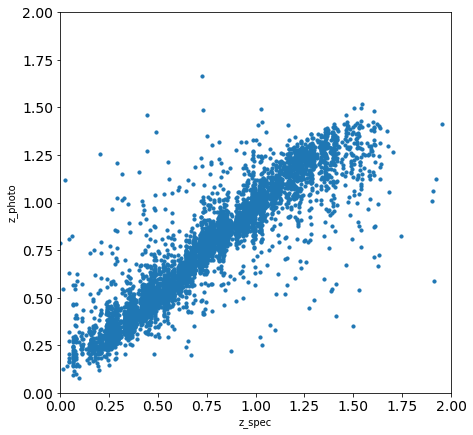

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.xlabel('z_spec')
plt.ylabel('z_photo')
plt.ylim(0,2)
plt.xlim(0,2)

Calculate the outlier fraction:

In [ ]:
len(np.where(np.abs(sel_target-ypred)>0.15*(1+sel_target))[0])/len(sel_target)

0.05676232757253845

Calculate Normalized Median Absolute Deviation (NMAD).

In [ ]:
1.48*np.median(np.abs(sel_target-ypred)/(1 + sel_target))

0.03675359420949169

### Conclusion: How does our model compare with the paper's results?

We are doing slightly worse, but we have a secret weapon in feature engineering.

### Can you think of a feature engineering exercise that can be helpful? (if you need a hint: it's in Section 7 of the paper ;) )









### <font color='blue'> Until now, we have never discussed a very important point: how to estimate the uncertainty associated to our results. </font>

One source of scatter on the global performance metrics comes from the system's architecture: we should generate a bunch of predictions with several random seeds. This is equivalent to the scatter found in the monitored metric (e.g., MSE or r2 score) in cross validation.

In [ ]:
model = RandomForestRegressor(max_features=4, n_estimators=200) #I need to re-seed the random state

In [ ]:
#Note: this also takes time!

seeds = np.random.choice(100,8, replace = False) #pick 8

olf = np.zeros(8)
NMAD = np.zeros(8)

for i in range(8): #A bit rough, but it gives a sense of what happens by varying the random seeds!
    print('Iteration', i)
    ypred = cross_val_predict(RandomForestRegressor(max_features=4, n_estimators=200,random_state=seeds[i]), sel_features, sel_target, cv = KFold(n_splits=5, shuffle=True, random_state=seeds[i]))
    olf[i] = len(np.where(np.abs(sel_target-ypred)>0.15*(1+sel_target))[0])/len(sel_target)
    NMAD[i] = 1.48*np.median(np.abs(sel_target-ypred)/(1 + sel_target))

print('OLF avg/std:, {0:.5f}, {1:0.5f}'.format(olf.mean(), olf.std()))
print('NMAD avg/std:, {0:.5f}, {1:0.5f}'.format(NMAD.mean(), NMAD.std()))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
OLF avg/std:, 0.03676, 0.00082
NMAD avg/std:, 0.01904, 0.00017


#### However, we should also think about how to quantify the observational error on our *individual* inputs.

The literature on this subjects is scarce, but my proposal is to run a forward-pass of the best model a bunch of times, with different inputs that are drawn from modeling each input according to their noise profile (e.g. a Gaussian where mean = observed value and sigma = experimental error).

Assuming that the noise profile doesn't change from the "true" value to the "observed" value, this should include the experimental error and the "limited information" error, which comes from limited training set size, lack of informative features, model architecture etc. This has been described as epistemic vs aleatoric uncertainty (see [this recent review](https://link.springer.com/article/10.1007/s10994-021-05946-3)).